In [269]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
def initialize_parameters_deep(layer_dims):
    N = layer_dims[0]
    xavier = 1 / N
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters[l] = {
            'W': np.random.randn(layer_dims[l], layer_dims[l-1]) * xavier,
            'b': np.zeros((layer_dims[l], 1))
        }
        
    return parameters

In [271]:
def linear_activation_forward(A, W, b, activation):
    Z = np.dot(W, A) + b
    p_A = A
    
    if activation == "sigmoid":
        A, Z = sigmoid(Z)
    
    elif activation == "relu":
        A, Z = relu(Z)
    
    cache2 = {
        'A': p_A,
        'W': W,
        'Z': Z
    }

    return A, cache2

In [272]:
def L_model_forward(X, parameters):
    caches = {}
    A = X
    L = len(parameters) # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        params = parameters[l]
        A, cache = linear_activation_forward(A_prev, params['W'], params['b'], 'relu')
        caches[l-1] = cache
            
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    params = parameters[L]
    AL, cache, = linear_activation_forward(A, params['W'], params['b'], 'sigmoid')
    caches[L-1] = cache
            
    return AL, caches

In [273]:
def compute_cost(A, Y):
    m = Y.shape[1]
    
    # Compute loss from aL and y.
    cost = np.mean(np.sum(((Y * np.log(A)) + ((1 - Y) * (np.log(1 - A)))), axis=1, keepdims=True) / -m)
#     cost = np.mean(np.sum(((-np.dot(Y,np.log(A).T) - np.dot(1-Y, np.log(1 - A).T)) / m), axis=1, keepdims=True))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [280]:
def linear_activation_backward(dA, cache, activation):    
    if activation == "relu":
        dZ = relu_backward(dA, cache['Z'])
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, cache['Z'])
    
    A_prev = cache['A']
    W = cache['W']
    m = A_prev.shape[1]
    dW = (np.dot(dZ, A_prev.T)) / m
    db = (np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [275]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[len(caches)-1]
    dA, dW, db = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads[L] = {
        'dA': dA,
        'dW': dW,
        'db': db
    }
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA, dW, db = linear_activation_backward(grads[l+2]['dA'], current_cache, 'relu')
        grads[l+1] = {
            'dA': dA,
            'dW': dW,
            'db': db
        }

    return grads

In [276]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)

    for l in range(L):
        params = parameters[l+1]
        parameters[l+1]['W'] = params['W'] - (learning_rate * grads[l+1]['dW'])
        parameters[l+1]['b'] = params['b'] - (learning_rate * grads[l+1]['db'])
        
    return parameters

In [277]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

label:0


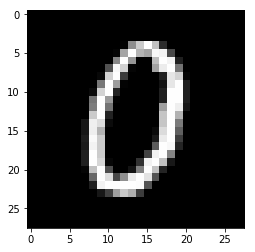

In [278]:
def to_one_hot(Y, num_items):
    newY = np.zeros((0, num_items))
    i = 0
    for y in Y:
        newy = np.zeros((1, num_items))
        newy[0, y[0]] = 1
        newY = np.append(newY, newy, axis=0)
    return newY

file_name = './input/train.csv'
df = pd.read_csv(file_name, header = 0)

original_headers = list(df.columns.values)
numpy_array = df.as_matrix()

numpy_array_random = numpy_array[:, :]
# np.random.shuffle(numpy_array_random)

num_items = 10
Y_orig = numpy_array_random[:, 1:2]
Y = to_one_hot(Y_orig, num_items).T
X = numpy_array_random[:, 2:].T
X_count, m = X.shape
x_count = int(np.sqrt(X_count))

X = (X - 128) / 128

index = 5
item = X[:, index]
img_X = item.reshape((x_count, x_count))
plt.imshow(img_X, shape=(x_count, x_count))
print('label:' + str(Y_orig[index, 0]))

trainSize = 25000
devSize = (m - trainSize) // 2
train_X, dev_X, test_X = X[:, :trainSize], X[:, trainSize:(trainSize + devSize)], X[:, (trainSize + devSize):]
train_Y, dev_Y, test_Y = Y[:, :trainSize], Y[:, trainSize:(trainSize + devSize)], Y[:, (trainSize + devSize):]

In [ ]:
NN_shape = [X_count, 20, 15, num_items]
parameters = L_layer_model(train_X, train_Y, NN_shape, learning_rate = 2.5, num_iterations = 5000, print_cost = True)

# Cost after iteration 0: 0.693153
# Cost after iteration 100: 0.321805
# Cost after iteration 200: 0.318209
# Cost after iteration 300: 0.324920
# Cost after iteration 400: 0.324920
# Cost after iteration 500: 0.324920
# Cost after iteration 600: 0.324919

Cost after iteration 0: 0.693147


In [ ]:
# pred_train = predict(train_X, train_Y, parameters)

In [217]:
from sklearn import metrics

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    newY = np.zeros((1, y.shape[1]))
    newProbas = np.zeros((1, probas.shape[1]))
    
    no_equal_cnt = 0
    images_count = 0
    for i in range(0, y.shape[1]):
        newY[0, i] = np.argmax(y[:, i], axis=0)
        newProbas[0, i] = np.argmax(probas[:, i], axis=0)
        
        if newY[0, i] != newProbas[0, i]:
            no_equal_cnt += 1
            
            if images_count < 10:
                print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
                item = X[:, i]
                plt.figure()
                plt.imshow(item.reshape((28, 28)), shape=(28, 28))
                plt.show()
                print('prediced label: ' + str(newProbas[0, i]) + ' || real label: ' + str(newY[0, i]))
                images_count += 1
    
    print('')
    print('not equal cnt: ' + str(no_equal_cnt))
    print('')
    print('')
    print(metrics.classification_report(newProbas.T, newY.T))
    return probas

pred_dev = predict(dev_X, dev_Y, parameters)

KeyError: 1